In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from showit import image
import pprint

from starfish import data, FieldOfView
from starfish.types import Features, Axes

In [2]:
use_test_data = os.getenv("USE_TEST_DATA") is not None
experiment = data.ISS(use_test_data=use_test_data)


# s.image.squeeze() simply converts the 4D tensor H*C*X*Y into a list of len(H*C) image planes for rendering by 'tile'

In [3]:
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(experiment._src_doc)

{ 'codebook': 'codebook.json',
  'extras': {},
  'images': { 'dots': 'dots.json',
              'nuclei': 'nuclei.json',
              'primary': 'hybridization.json'},
  'version': '5.0.0'}


In [4]:
fov = experiment.fov()
primary_image = fov[FieldOfView.PRIMARY_IMAGES]
dots = fov['dots']
nuclei = fov['nuclei']
images = [primary_image, nuclei, dots]

100%|██████████| 1/1 [00:00<00:00, 30.25it/s]


In [5]:
# round, channel, x, y, z
primary_image.xarray.shape

(4, 4, 1, 1044, 1390)

100%|██████████| 1/1 [00:00<00:00, 246.93it/s]


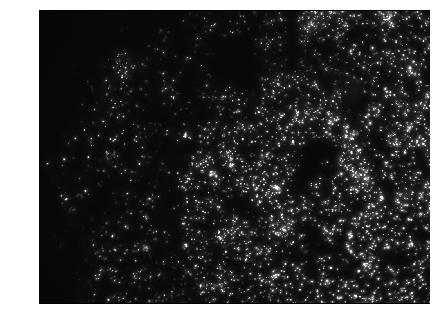

In [6]:
dots_mp = dots.max_proj(Axes.ROUND, Axes.CH, Axes.ZPLANE)
dots_mp_numpy = dots._squeezed_numpy(Axes.ROUND, Axes.CH, Axes.ZPLANE)
image(dots_mp_numpy)

100%|██████████| 1/1 [00:00<00:00, 160.23it/s]


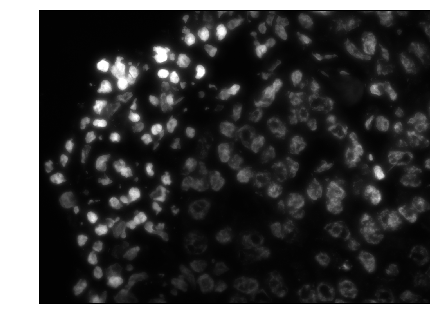

In [7]:
nuclei_mp = nuclei.max_proj(Axes.ROUND, Axes.CH, Axes.ZPLANE)
nuclei_mp_numpy = nuclei_mp._squeezed_numpy(Axes.ROUND, Axes.CH, Axes.ZPLANE)
image(nuclei_mp_numpy)

In [8]:
experiment.codebook

<xarray.Codebook (target: 31, c: 4, r: 4)>
array([[[0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]],

       [[0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0],
        [1, 0, 0, 0]],

       ...,

       [[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0]],

       [[0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0]]], dtype=uint8)
Coordinates:
  * target   (target) object 'SCUBE2' 'MYBL2' 'ER' 'ST-3' 'BCL2' 'MET' ...
  * c        (c) int64 0 1 2 3
  * r        (r) int64 0 1 2 3

In [9]:
from starfish.image import Filter

# filter raw data
masking_radius = 15
filt = Filter.WhiteTophat(masking_radius, is_volume=False)
for img in images:
    filt.run(img, verbose=True, in_place=True)

16it [00:00, 113.22it/s]
1it [00:00, 25.06it/s]
1it [00:00, 27.41it/s]


In [10]:
from starfish.image import Registration

registration = Registration.FourierShiftRegistration(
    upsampling=1000,
    reference_stack=dots,
    verbose=True)
registered_image = registration.run(primary_image, in_place=False)

100%|██████████| 1/1 [00:00<00:00, 168.15it/s]


For round: 0, Shift: [  5.788 -22.819], Error: 0.5738049024566524
For round: 1, Shift: [  1.88  -22.189], Error: 0.7196118658307065
For round: 2, Shift: [ -3.245 -21.912], Error: 0.8182548925522324
For round: 3, Shift: [ -4.425 -14.923], Error: 0.8024235927697199


In [11]:
from starfish.spots import SpotFinder
import warnings

# parameters to define the allowable gaussian sizes (parameter space)
min_sigma = 1
max_sigma = 10
num_sigma = 30
threshold = 0.01

p = SpotFinder.BlobDetector(
    min_sigma=min_sigma,
    max_sigma=max_sigma,
    num_sigma=num_sigma,
    threshold=threshold,
    measurement_type='mean',
)

# detect triggers some numpy warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # blobs = dots; define the spots in the dots image, but then find them again in the stack.
    dots = dots.max_proj(Axes.ROUND, Axes.ZPLANE)
    dots_numpy = dots._squeezed_numpy(Axes.ROUND, Axes.ZPLANE)
    blobs_image = dots_numpy
    intensities = p.run(registered_image, blobs_image=blobs_image)

100%|██████████| 1/1 [00:00<00:00, 160.52it/s]


In [12]:
decoded = experiment.codebook.decode_per_round_max(intensities)

In [13]:
genes, counts = np.unique(decoded.loc[decoded[Features.PASSES_THRESHOLDS]][Features.TARGET], return_counts=True)
table = pd.Series(counts, index=genes).sort_values(ascending=False)

100%|██████████| 1/1 [00:00<00:00, 188.90it/s]
/Users/sbergenholtz/Applications/starfish/starfish/.venv/lib/python3.7/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)


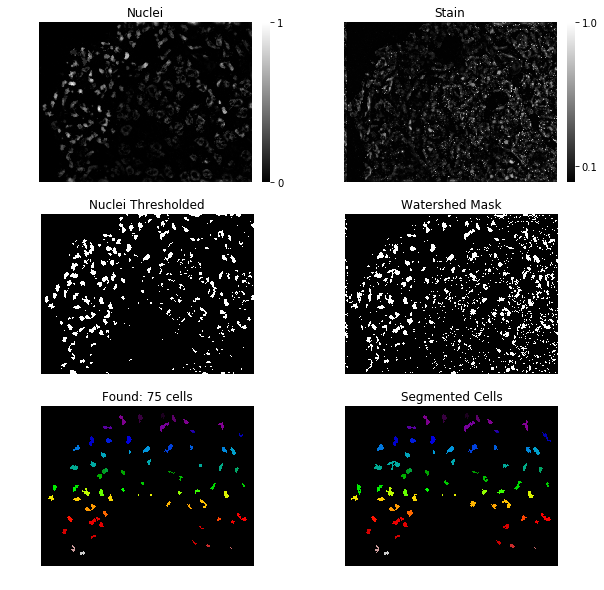

In [14]:
from starfish.image import Segmentation

dapi_thresh = .16  # binary mask for cell (nuclear) locations
stain_thresh = .22  # binary mask for overall cells // binarization of stain
min_dist = 57

registered_mp = registered_image.max_proj(Axes.CH, Axes.ZPLANE)
registered_mp_numpy = registered_mp._squeezed_numpy(Axes.CH, Axes.ZPLANE)
stain = np.mean(registered_mp_numpy, axis=0)
stain = stain/stain.max()
nuclei = nuclei.max_proj(Axes.ROUND, Axes.CH, Axes.ZPLANE)
nuclei_numpy = nuclei._squeezed_numpy(Axes.ROUND, Axes.CH, Axes.ZPLANE)

seg = Segmentation.Watershed(
    nuclei_threshold=dapi_thresh,
    input_threshold=stain_thresh,
    min_distance=min_dist
)
label_image = seg.run(registered_image, nuclei)
seg.show()

100%|██████████| 1/1 [00:00<00:00, 177.39it/s]


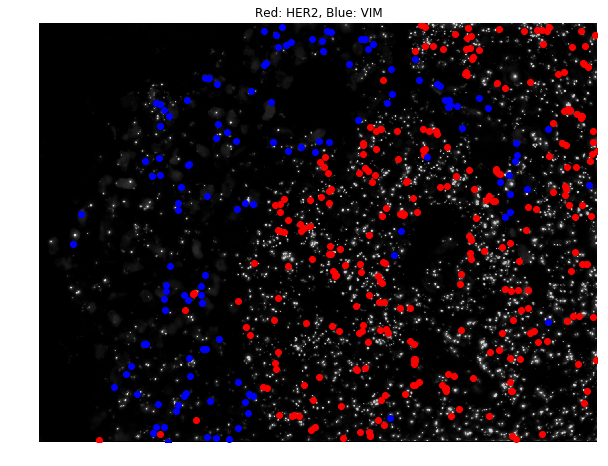

In [15]:
from skimage.color import rgb2gray

GENE1 = 'HER2'
GENE2 = 'VIM'

rgb = np.zeros(registered_image.tile_shape + (3,))
nuclei_mp = nuclei.max_proj(Axes.ROUND, Axes.CH, Axes.ZPLANE)
nuclei_numpy = nuclei_mp._squeezed_numpy(Axes.ROUND, Axes.CH, Axes.ZPLANE)
rgb[:,:,0] = nuclei_numpy
dots_mp = dots.max_proj(Axes.ROUND, Axes.CH, Axes.ZPLANE)
dots_mp_numpy = dots_mp._squeezed_numpy(Axes.ROUND, Axes.CH, Axes.ZPLANE)
rgb[:,:,1] = dots_mp_numpy
do = rgb2gray(rgb)
do = do/(do.max())

image(do,size=10)
with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)
    is_gene1 = decoded.where(decoded[Features.AXIS][Features.TARGET] == GENE1, drop=True)
    is_gene2 = decoded.where(decoded[Features.AXIS][Features.TARGET] == GENE2, drop=True)

plt.plot(is_gene1.x, is_gene1.y, 'or')
plt.plot(is_gene2.x, is_gene2.y, 'ob')
plt.title(f'Red: {GENE1}, Blue: {GENE2}');